# Other Models

This notebook explores if the relationship between degree and score holds across different knowledge graph embedding models.

## Setup

We now load the required packages, then load and preprocess the Hetionet. Please see the `target_prediction` notebook for a more in-depth explanation of these steps.

In [30]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pykeen.datasets.hetionet import Hetionet
from scipy import stats

from src.utils import get_predictions_tail

sns.set_theme(style="darkgrid", palette="muted", font_scale=1.5)

In [31]:
data = Hetionet(random_state=42)
data.summarize()  # Summarize the dataset to ensure it is downloaded
# Load the Hetionet edges as downloaded by the PyKEEN dataloader
df = pd.read_csv(
    "~/.data/pykeen/datasets/hetionet/hetionet-v1.0-edges.sif.gz", sep="\t"
)
# Load these edges into a NX graph and compute the degree for each entity
G = nx.from_pandas_edgelist(df, "source", "target", create_using=nx.MultiGraph())
degs = dict(G.degree())

Hetionet (create_inverse_triples=False)
Name        Entities    Relations      Triples
----------  ----------  -----------  ---------
Training    45158       24             1800157
Testing     45158       24              225020
Validation  45158       24              225020
Total       -           -              2250197
Head                     Relation    tail
-----------------------  ----------  ------------
Anatomy::UBERON:0000002  AdG         Gene::10005
Anatomy::UBERON:0000002  AdG         Gene::114804
Anatomy::UBERON:0000002  AdG         Gene::118670
Anatomy::UBERON:0000002  AdG         Gene::128989
Anatomy::UBERON:0000002  AdG         Gene::132851



## Load All Models

Here we load three different models: DistMult, RotatE and TransH. Note that if you want to rerun this notebook, these models will have to be retrained using the train.py script. Then point to the appropriate paths for each model in the loading process below.

In [32]:
# Load the pretrained models
distmult_model = torch.load(
    "distmult_hetnet.pkl",
    map_location=torch.device("cpu"),
)

rotate_model = torch.load(
    "rotate_hetnet.pkl",
    map_location=torch.device("cpu"),
)

transh_model = torch.load(
    "transh_hetnet.pkl",
    map_location=torch.device("cpu"),
)

## Plotting Correlation Between Degree and Disease Association

We now use these pretrained model to make predictions and assess the correlation between gene degree and the score assigned by the model for association between gene and disease. 

We first define the diseases we are assessing, we well as the relation type we are querying the model on. This being the Disease->associates->Gene (DaG) relation type.

In [33]:
melanoma: str = "Disease::DOID:1909"
parkinsons: str = "Disease::DOID:14330"
fallopian_tube_cancer: str = "Disease::DOID:1964"

query_relation: str = "DaG"

In [34]:
def plot_score_degree_gene(df: pd.DataFrame, text: str) -> None:
    def annotate(data, **kws):

        _, _, r_value, _, _ = stats.linregress(np.log10(df["deg"]), df["score"])
        ax = plt.gca()
        ax.text(0.05, 0.8, f"$R^2$: {r_value**2:.2f}", transform=ax.transAxes)

    ax = sns.lmplot(
        data=df,
        x="deg",
        y="score",
        hue="triple_type",
        hue_order=["novel", "train", "test"],
        logx=True,
        n_boot=10000,
        seed=0,
        height=6,
        aspect=1.2,
    )
    ax.map_dataframe(annotate)
    ax.set(
        xscale="log",
        xlabel="Degree (log)",
        ylabel="Predicted Score",
        xlim=(0.5, 11000),
        title=f"Degree Vs. Score for Genes: {text}",
    )
    ax.legend.set_title("Triple Type")
    ax.legend.set_bbox_to_anchor((0.95, 0.5))
    plt.show()

### DistMult - Parkinson's

We can now see how DistMult performs when predicting genes likely to be associated with Parkinson's. We can see the trend of higher connected genes receiving a higher score from the model for diseases association.

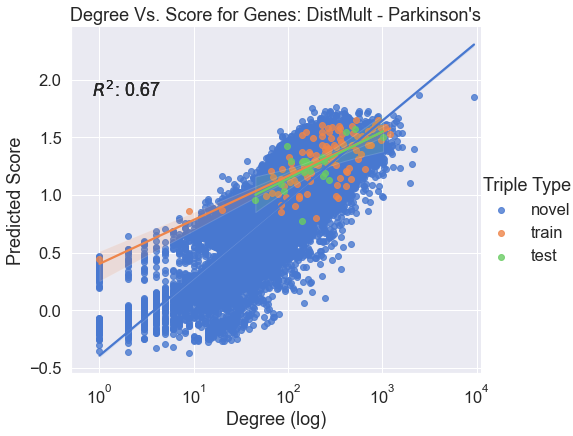

In [35]:
predictions_df = get_predictions_tail(
    parkinsons, query_relation, data, distmult_model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_score_degree_gene(predictions_df, "DistMult - Parkinson's")

### RotatE - FTC

We now see that this relationship holds for the RotatE model and Fallopian Tube Cancer.

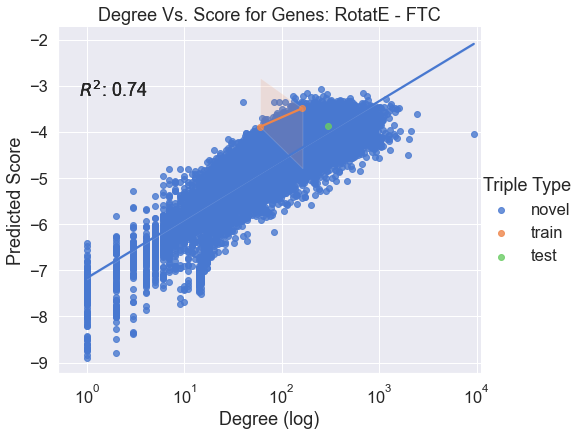

In [36]:
predictions_df = get_predictions_tail(
    fallopian_tube_cancer, query_relation, data, rotate_model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_score_degree_gene(predictions_df, "RotatE - FTC")

### TransH - Melanoma

Finally we see the relationship holds for the TransH model and Melanoma.

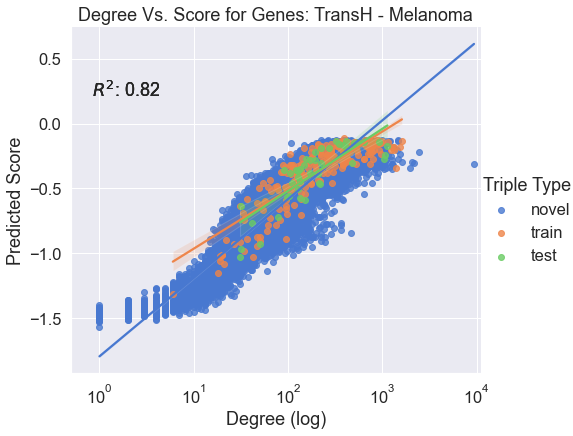

In [37]:
predictions_df = get_predictions_tail(
    melanoma, query_relation, data, transh_model, degs
)
predictions_df = predictions_df[predictions_df.entity_type == "Gene"]
plot_score_degree_gene(predictions_df, "TransH - Melanoma")